In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow.keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os
from collections import Counter

# Dataset Read


In [12]:
# Define labels and image size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 112  # Match IMG_SHAPE

In [13]:
#Function to load data with file extension filter
def get_training_data(data_dir):
    images = []
    labels_list = []
    valid_extensions = ('.jpg', '.jpeg', '.png')  # Define valid image extensions
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            # Check if the file has a valid image extension
            if not img.lower().endswith(valid_extensions):
                print(f"Skipping non-image file: {os.path.join(path, img)}")
                continue
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels_list.append(class_num)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels_list)

In [14]:
import os

# Set this to the actual path where the dataset is located on your system
dataset_path = r"K:\User\Dektop\College\Nti Huawei\Project\chest_xray\chest_xray"  # <-- update this with your actual path

print("dataset path:", dataset_path)

# Now load the data using your loading function
train_data, train_labels = get_training_data(os.path.join(dataset_path, "train"))
test_data, test_labels = get_training_data(os.path.join(dataset_path, "test"))
val_data, val_labels = get_training_data(os.path.join(dataset_path, "val"))


dataset path: K:\User\Dektop\College\Nti Huawei\Project\chest_xray\chest_xray


In [15]:
x_train = np.array(train_data) / 255
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(train_labels)

x_test = np.array(test_data) / 255
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_labels)

x_val = np.array(val_data) / 255
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(val_labels)

In [16]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(0.6730322580645162), 1: np.float64(1.9448173005219984)}


# Data Visualization

C:\Users\khahm\AppData\Local\Temp\ipykernel_1028\1830745542.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_train, palette="Blues")


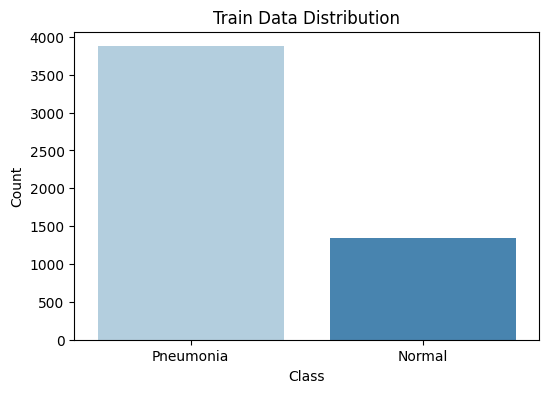

In [17]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

df_train = pd.DataFrame({'Label': l})

plt.figure(figsize=(6,4))

sns.countplot(x='Label', data=df_train, palette="Blues")
plt.title("Train Data Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()   

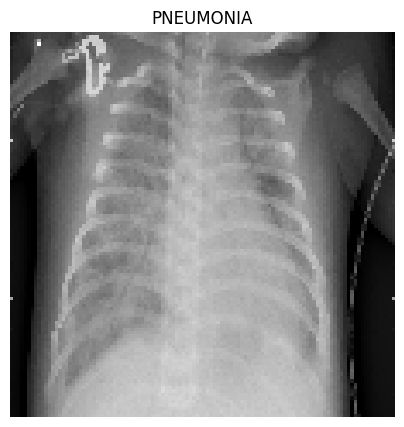

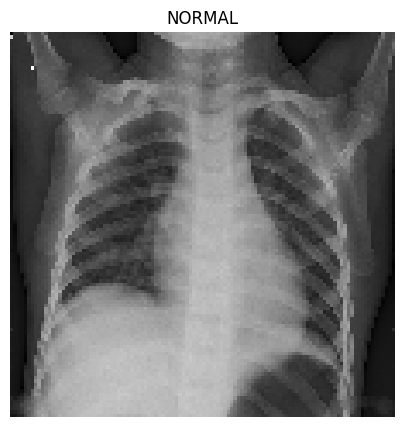

In [18]:
la = ['PNEUMONIA', 'NORMAL']

plt.figure(figsize=(5,5))
plt.imshow(x_train[0], cmap='gray')
plt.title(la[y_train[0]])  
plt.axis('off')  
plt.show()


plt.figure(figsize=(5,5))
plt.imshow(x_train[-1], cmap='gray')
plt.title(la[y_train[-1]])  
plt.axis('off')
plt.show()



#  Data Preprocessing & Augmentation



In [19]:
img = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)
img.fit(x_train)

In [ ]:
from tensorflow.keras.layers import MaxPool2D
model_2 = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            strides=1,
            padding="same",
            activation="relu",
            input_shape=(112, 112, 1),
        ),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.1),
        BatchNormalization(),

        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),

        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),

        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        
        MaxPool2D((2, 2), strides=2, padding="same"),
        Flatten(),
        Dense(units=128, activation="relu"),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid"),
    ]
)
model_2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.3, min_lr=0.000001
)
print("Learning Rate Reduction", learning_rate_reduction)

Learning Rate Reduction <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x0000017654404350>


In [26]:
# Compile the model
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train model
model_2.fit(
    img.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=img.flow(x_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12


c:\Users\khahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 678ms/step - accuracy: 0.7261 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 624ms/step - accuracy: 0.7399 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7530 - loss: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.7529 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.7416 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7275 - loss: 0.0000e+00
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━

In [27]:
# Evaluate model
x_test_precosses = x_test
y_test_encoded = y_test
loss, accuracy = model_2.evaluate(x_test_precosses, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8533 - loss: 0.0000e+00
Test loss: 0.0000
Test accuracy: 0.6231


In [ ]:
# Predict and evaluate
y_pred_prob = model_2.predict(x_test_precosses)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred_prob.flatten()])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


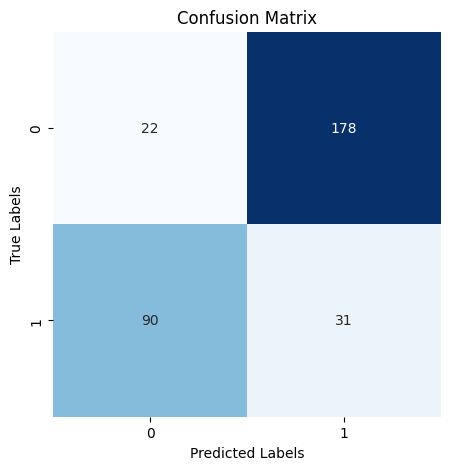

In [ ]:
# Confusion matrix
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# Classification report
print(classification_report(y_test_encoded, y_pred, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.20      0.11      0.14       200
      NORMAL       0.15      0.26      0.19       121

    accuracy                           0.17       321
   macro avg       0.17      0.18      0.16       321
weighted avg       0.18      0.17      0.16       321

